# Clipping data


Clipping is a process used to extract specific parts of data based on a predefined layer that represents the area of interest. The `geopandas` and `matplotlib` packages are used for this process.

In [71]:
import geopandas as gp
import matplotlib.pyplot as plt
from pathlib import Path

INPUT = Path.cwd().parents[0] / "00_data"
OUTPUT = Path.cwd().parents[0] / "out"
OUTPUT.mkdir(exist_ok=True)

gdb_path = INPUT / "LBM_2018_IS_DD_gdb" / "LBM_2018_IS_DD.gdb"

The areas of interest in this chapter are districts in Dresden. 

`````{admonition} Dresden Portal!
:class: tip, dropdown
The districts are extracted from the [Portal of Dresden](https://opendata.dresden.de/informationsportal/?open=1&result=493101D03C794E9C99CD8B2BAC194FEC#app/mainpage////).
`````

For retrieving the data, from the Geojson section of the portal, based on the interested format, the URL is chosen.

In [72]:
geojson_url = "https://kommisdd.dresden.de/net4/public/ogcapi/collections/L137/items"

Then the `requests` library is imported and a request is sent to the portal to extract the data.

In [73]:
import requests

response = requests.get(geojson_url)

Then if the request is successful (code 200), it will load and plot the data.

In [90]:
if response.status_code == 200:
    gdf = gp.read_file(geojson_url)
    print(gdf.head())
    gdf.plot()
    
else:
    print("Error:", response.text)

   id                   bez  \
0  44        Dresdner Heide   
1  42  Bühlau/Weißer Hirsch   
2  13       Innere Neustadt   
3  15           Albertstadt   
4  24               Trachau   

                                            bez_lang  flaeche_km2   sst  \
0                                     Dresdner Heide      48.3382  None   
1  Bühlau/Weißer Hirsch mit Rochwitz und Loschwit...       6.7596  None   
2                 Innere Neustadt mit Antonstadt-Süd       1.7903  None   
3                                        Albertstadt       7.4935  None   
4                                            Trachau       3.5192  None   

  sst_klar historie                 aend  \
0     None      akt  01.08.2024 00:00:00   
1     None      akt  01.08.2024 00:00:00   
2     None      akt  01.08.2024 00:00:00   
3     None      akt  01.08.2024 00:00:00   
4     None      akt  01.08.2024 00:00:00   

                                            geometry  
0  POLYGON ((13.87262 51.12741, 13.87258 5

`````{admonition} Selecting the area of interest!
:class: tip, dropdown
To select the area of interest, the methods mentioned in the Selecting and Filtering chapter could be used, but also it is possible to add the labels to maps and select based on labels.
`````

To add the labels, first, the position of the labels should be defined.

The centroid of the polygons would be the position of the labels and is generated using the `geometry.centroid` method and stored in a new column.

In [ ]:
gdf["centroid"] = gdf.geometry.centroid 

For adding the labels the `text` function is used.

The coordinates of the centroid are the position of the labels and the label text is defined with `str`.
In the following example, the IDs of the districts are used.

`````{admonition} Labels in the map!
:class: note, dropdown
To customize the labels more, check [here](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.text.html).
`````

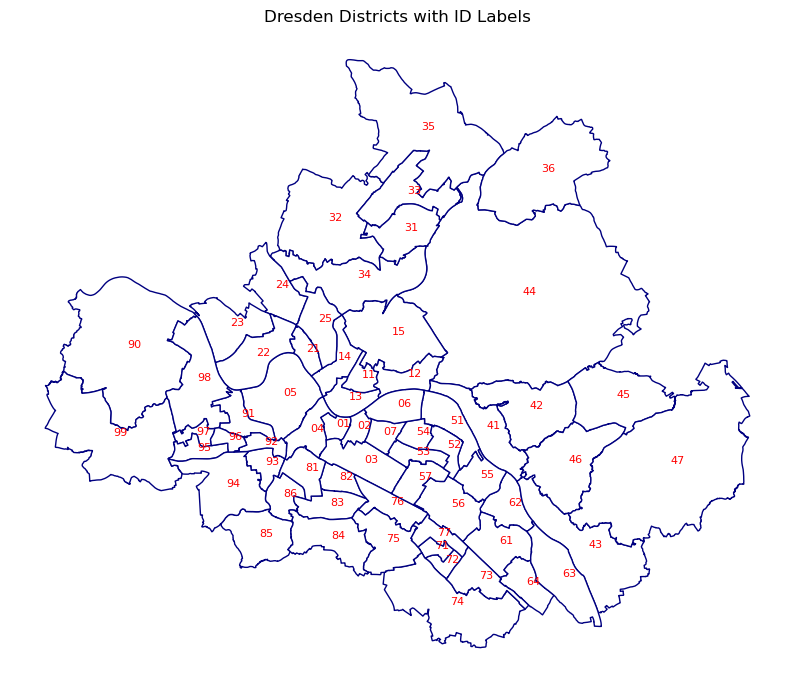

In [76]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='white', edgecolor='navy')
ax.set_axis_off()

for idx, row in gdf.iterrows():
    plt.text(row.centroid.x, row.centroid.y, str(row['id']),
             fontsize=8, 
             color='red')

plt.title("Dresden Districts with ID Labels")
plt.show()


Now using the labels the interested area is selected.

<Axes: >

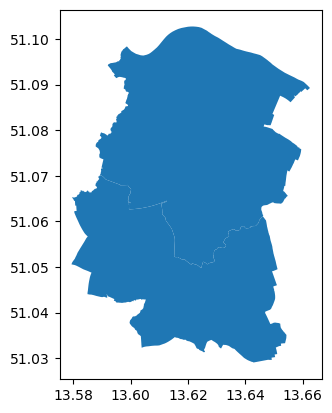

In [77]:
clipping_layer= gdf[gdf['id'].isin(['90','99'])]
clipping_layer.plot()

The path to the original dataset and the clipping layer, based on which the original layer should be clipped, will be defined.

In [78]:
original_layer = gp.read_file(gdb_path, layer="LBM2018_IS_DD")

The coordinate system of the layers is checked. If the coordinate systems do not match, the clipping process will not proceed.

In [79]:
original_layer.crs

<Projected CRS: EPSG:25833>
Name: ETRS89 / UTM zone 33N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 12°E and 18°E: Austria; Croatia; Denmark - offshore and offshore; Germany - onshore and offshore; Italy - onshore and offshore; Norway including Svalbard - onshore and offshore.
- bounds: (12.0, 34.79, 18.01, 84.01)
Coordinate Operation:
- name: UTM zone 33N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [80]:
clipping_layer.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

If the coordinate systems are not the same, they are transformed to match.

In [81]:
clipping_layer = clipping_layer.to_crs('EPSG:25833')

The dataset is then clipped by defining the original layer and the clipping layer using the `clip` function in the `geopandas` package.

In [82]:
clipped_layer = gp.clip(original_layer, clipping_layer)

And the result of the clip operation will be printed out.

In [83]:
clipped_layer.head(3)

,KS_IS,CLC_st1,CLC18,CLC,Biotpkt2018,Shape_Length,Shape_Area,geometry
261,SV,122,None,NaN,5.271487,1765.048621,6984.236836,"POLYGON ((404092.96 5654379.53, 404098.204 565..."
5928,BL,322,None,NaN,18.055116,204.848619,582.329680,"POLYGON ((404867.05 5654106.356, 404862.483 56..."
13027,None,142,142,142.0,7.000000,481.434416,11886.564349,"POLYGON ((405339.13 5654136.481, 405172.058 56..."


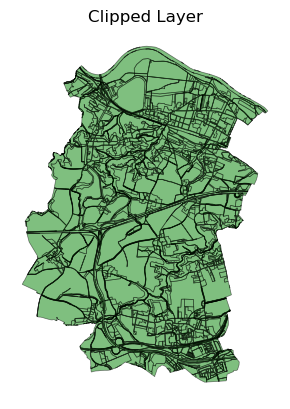

In [84]:
ax = clipped_layer.plot(color="green", linewidth=0.5, alpha=0.5, edgecolor="black")
ax.set_title("Clipped Layer")
ax.set_axis_off()

The result can be saved in various formats. All you need to do is define the output path and export based on the format you are interested in.

- Shapefile Format

In [ ]:
output_shp = OUTPUT / "clipped.shp"
clipped_layer.to_file(output_shp)

- GeoPackage Format 

In [86]:
output_gdb = OUTPUT / "clipped.gpkg"
clipped_layer.to_file(
    output_gdb, 
    layer="clipped_layer",
    driver="GPKG")

- CSV Format

```{admonition} **Geometry as WKT**
:class: caution, dropdown
If the layer doesn't have a geometry column in Well Known Text format, it should be converted first, which is mentioned in the next steps.
```

To convert the geometry to WKT, first access the geometry column of the GeoDataFrame. Then, use the `apply` function to convert each geometry in the column to a string format.

In [ ]:
clipped_layer["geometry"] = clipped_layer["geometry"].apply(lambda geom: geom.wkt)

The output path is defined, and the data is saved as a CSV file. If the index column, which represents unique values for rows, is not needed, the `index` parameter can be set to `False`.

```{admonition} **Parameters for CSV file**
:class: tip
To learn how to customize your CSV data, visit the pandas DataFrame to CSV page [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html).
```

In [88]:
csv_path = OUTPUT / "clipped_layer.csv"

In [89]:
clipped_layer.to_csv(csv_path, index=True)